In [33]:
## IMPORT 

import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
from scipy.signal import resample
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h5py as h5
import h5py
from pathlib import Path

In [34]:
## LOADING THE MF HDF5 File 

filename='1052_F_day1_.doric'
folder = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/ADFCFP/female/ADFCfemales/'
h5file = os.path.join(folder, filename)

## LOADING ANYMAZE FILE FOR TTL

TTL_an=pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/ADFCFP/female/TTL_females/1052_acquisition.csv')

# Extract ID, sex and stage of experiment

base_name = os.path.basename(filename)
name_parts = base_name.split('_')
mouse_id = name_parts[0]
sex = name_parts[1]
day_of_experiment = name_parts[2]



with h5py.File(h5file, 'r') as f:
    # Find the channel signal from DORIC file
    folder = f['DataAcquisition']['EPConsole']['Signals']['Series0001']
    
    # Get time
    raw_time = folder['AIN01xAOUT01-LockIn']['Time']
    

    # Get signal
    values_gcamp = folder['AIN01xAOUT01-LockIn']['Values']
    values_iso = folder['AIN01xAOUT02-LockIn']['Values']
    values_rcamp = folder['AIN02xAOUT03-LockIn']['Values']

    #Get TLL 
    raw_dio_time = folder['DigitalIO']['Time']
    raw_TTL_wn = folder['DigitalIO']['DIO02']
    raw_TTL_tone = folder['DigitalIO']['DIO03']


    #Read the data 
    raw_time = raw_time[:]
    values_gcamp = values_gcamp[:]
    values_iso =  values_iso[:]
    values_rcamp = values_rcamp[:]
    raw_TTL_wn = raw_TTL_wn[:]
    raw_TTL_tone = raw_TTL_tone[:]
    raw_dio_time = raw_dio_time[:]

    #Sanity check for the win
    print("Raw Time (first 5):", raw_time[:5])
    print("Values gcamp (first 5):", values_gcamp[:5])
    print("values rcamp (first 5)", values_rcamp[:5])
    print("Values iso (first 5):", values_iso[:5])
    print("raw dio time (first 5)", raw_dio_time[:5])
    print("TTL_wn:", raw_TTL_wn[:5])
    print(len(values_gcamp))
    print(len(raw_TTL_tone))


Raw Time (first 5): [0.089059 0.105659 0.122259 0.138859 0.155459]
Values gcamp (first 5): [0.21036299 0.21074281 0.21130471 0.21122061 0.2106182 ]
values rcamp (first 5) [7.98535848e-05 1.27272166e-04 1.81365309e-04 1.43138481e-04
 6.16933092e-05]
Values iso (first 5): [0.23785239 0.2381447  0.23783681 0.23659265 0.23495809]
raw dio time (first 5) [0.00498 0.02158 0.03818 0.05478 0.07138]
TTL_wn: [0. 0. 0. 0. 0.]
115661
115673


Average Sampling Interval: 0.01660001435241224 seconds
Sampling Frequency: 60.24091177093979 Hz
duration:, 1919.95766 seconds
Average Sampling Interval after resampling: 0.016668447368877935 seconds
Sampling Frequency after resampling: 59.99359015688074 Hz
(115198,)
(115198,)
(115198,)
1920.046719
1920.16184


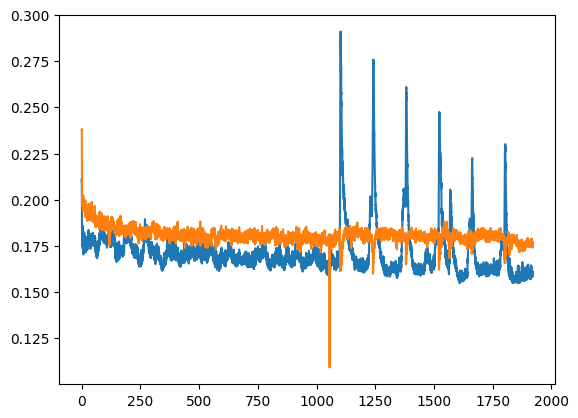

In [35]:
#RESAMPLING 
##Check the sampling 

# Calculate the differences between consecutive time points
time_differences = np.diff(raw_time)
average_sampling_interval = np.mean(time_differences)

# Calculate the sampling frequency
sampling_frequency = 1 / average_sampling_interval

print(f"Average Sampling Interval: {average_sampling_interval} seconds")
print(f"Sampling Frequency: {sampling_frequency} Hz")


### RESAMPLING 
duration = raw_time[-1] - raw_time[0]

new_sampling_rate = 60  # Hz
num_samples_resampled = int(duration * new_sampling_rate) + 1 ##Integer because can't be a fraction

# Resample gcamp + iso + TTL 
resampled_gcamp, time = resample(values_gcamp, num_samples_resampled, t=raw_time)
resampled_rcamp, time = resample(values_rcamp, num_samples_resampled, t=raw_time)
resampled_iso, time = resample(values_iso, num_samples_resampled, t=raw_time)
resampled_TTL_wn, time = resample(raw_TTL_wn, num_samples_resampled, t=raw_time) ##CAREFUL USING THIS, TTL TIME IS HERE CONSIDERED AS GCAMP TIME, IT'S AN APPROXIMATION, ALWAYS CHECK IF MAKES SENSE
resampled_TTL_tone, time = resample(raw_TTL_tone, num_samples_resampled, t=raw_time) ##CAREFUL USING THIS, TTL TIME IS HERE CONSIDERED AS GCAMP TIME, IT'S AN APPROXIMATION, ALWAYS CHECK IF MAKES SENSE

print(f"duration:, {duration} seconds")

## Sanity check for the win 
time_differences_resampled = np.diff(time)
average_sampling_interval_resampled = np.mean(time_differences_resampled)
sampling_frequency_resampled = 1 / average_sampling_interval_resampled

print(f"Average Sampling Interval after resampling: {average_sampling_interval_resampled} seconds")
print(f"Sampling Frequency after resampling: {sampling_frequency_resampled} Hz")
print(resampled_gcamp.shape)
print(resampled_rcamp.shape)
print(resampled_TTL_wn.shape)
print(raw_time[-1])
print(raw_dio_time[-1])

plt.plot(time, resampled_gcamp)
plt.plot(time, resampled_iso)

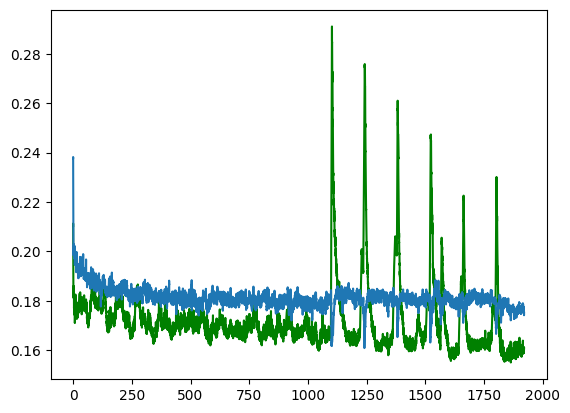

In [36]:
###Removing artifacts 

import numpy as np
from scipy.interpolate import interp1d

def remove_artifacts_and_interpolate(signal, time, threshold=0.0005, time_window=0.5):
    # Create a copy of the original signal
    cleaned_signal = signal.copy()

    # Define the sliding window size based on the time window
    window_size = np.sum(time <= time_window)

    # Iterate through the signal using a sliding window
    for i in range(len(cleaned_signal) - window_size):
        # Calculate the difference in signal within the window
        window_diff = cleaned_signal[i + window_size] - cleaned_signal[i]

        # If the difference exceeds the threshold, mark it as NaN
        if window_diff > threshold:
            cleaned_signal[i:i + window_size] = np.nan

    # Interpolate the NaN values
    nan_indices = np.isnan(cleaned_signal)
    interpolator = interp1d(time[~nan_indices], cleaned_signal[~nan_indices], kind='linear', fill_value='extrapolate')
    cleaned_signal[nan_indices] = interpolator(time[nan_indices])

    return cleaned_signal

# Apply the function to both 'resampled_gcamp' and 'resampled_iso'
resampled_gcamp = remove_artifacts_and_interpolate(resampled_gcamp, time)
resampled_iso = remove_artifacts_and_interpolate(resampled_iso, time)
resampled_rcamp = remove_artifacts_and_interpolate(resampled_rcamp, time)

# 'resampled_gcamp' and 'resampled_iso' now contain the cleaned signals


plt.plot(time, resampled_gcamp, color='g')
plt.plot(time, resampled_iso)

In [37]:
# ####ABBERRANCE DETECTION : WHEN SIGNAL FUCKS UP 

# # Calculate the first derivative of the signal
# signal_diff = np.diff(resampled_gcamp, prepend=resampled_gcamp[0])

# # Set a threshold for detecting large jumps in the signal
# threshold = np.std(signal_diff) * 20  # Adjust the factor as needed

# # Identify the indices where the signal changes significantly
# power_change_indices = np.where(np.abs(signal_diff) > threshold)[0]

# print("Detected power change points at indices:", power_change_indices)

In [38]:
# #### IF ABBERANCE DETECTED, CORRECTS IT 

# # Your resampled_gcamp signal and detected power change indices
# # resampled_gcamp is your signal array
# # power_change_indices contains the indices where signal changes (detected earlier)
# # Include the start and end of the signal in the indices
# power_change_indices = np.concatenate(([0], power_change_indices, [len(resampled_gcamp)]))

# # Initialize an array to store the corrected signal
# corrected_signal = np.copy(resampled_gcamp)

# # Scale each segment based on the mean of the first segment
# base_mean = np.mean(resampled_gcamp[power_change_indices[0]:power_change_indices[1]])

# # Loop over each segment and scale them
# for i in range(len(power_change_indices) - 1):
#     start_idx = power_change_indices[i]
#     end_idx = power_change_indices[i + 1]

#     # Calculate the mean of the current segment
#     segment_mean = np.mean(resampled_gcamp[start_idx:end_idx])

#     # Compute the scaling factor
#     scaling_factor = base_mean / segment_mean

#     # Scale the segment
#     corrected_signal[start_idx:end_idx] *= scaling_factor

# # Now corrected_signal contains the adjusted signal
# print("Signal successfully scaled across segments!")

# plt.figure(figsize=(10,6))
# plt.plot(time, resampled_gcamp, label='Original Signal', alpha=0.6)
# plt.plot(time, corrected_signal, label='Corrected Signal', alpha=0.8)
# plt.legend()
# plt.title('Original vs Corrected Signal')
# plt.show()

# len(resampled_gcamp)
# # len(corrected_signal)


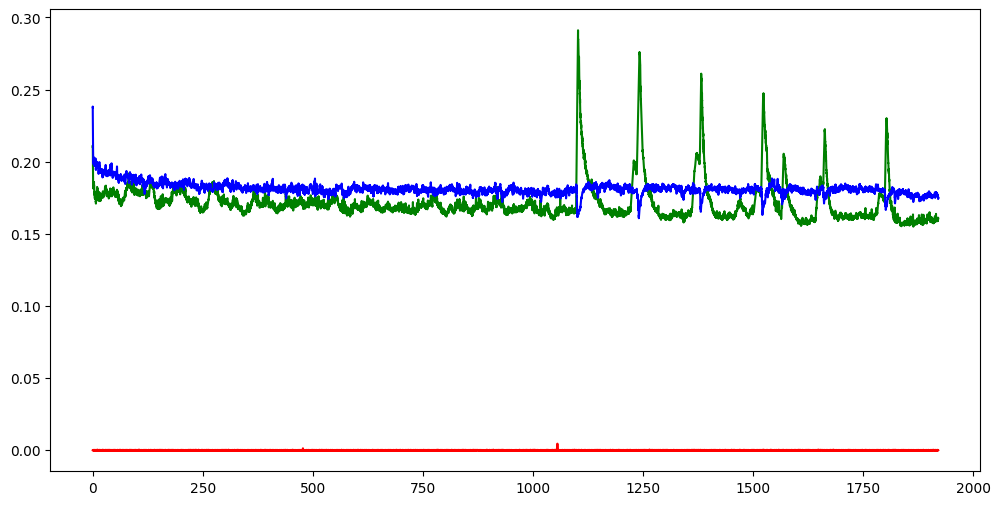

In [39]:

##RAW SIGNAL PLOT

# fig,ax1=plt.subplots(figsize=(12,6))  # create a plot to allow for dual y-axes plotting
# plot1=ax1.plot(time, resampled_gcamp, 'g', label='gcamp') 
# ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
# plot2=ax2.plot(time, resampled_iso, 'r', label='isosbestic') 
# # Labels
# lines = plot1 + plot2
# labels = [l.get_label() for l in lines]  
# legend = ax1.legend(lines, labels) 

# ax1.set_ylim(0.3, 0.8)
# ax2.set_ylim(0.3, 0.8)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time, resampled_gcamp, color='g', label='Smoothed FP Zscore (Savitzky-Golay)')
plt.plot(time, resampled_iso, color='b')
plt.plot(time, resampled_rcamp, color='r')

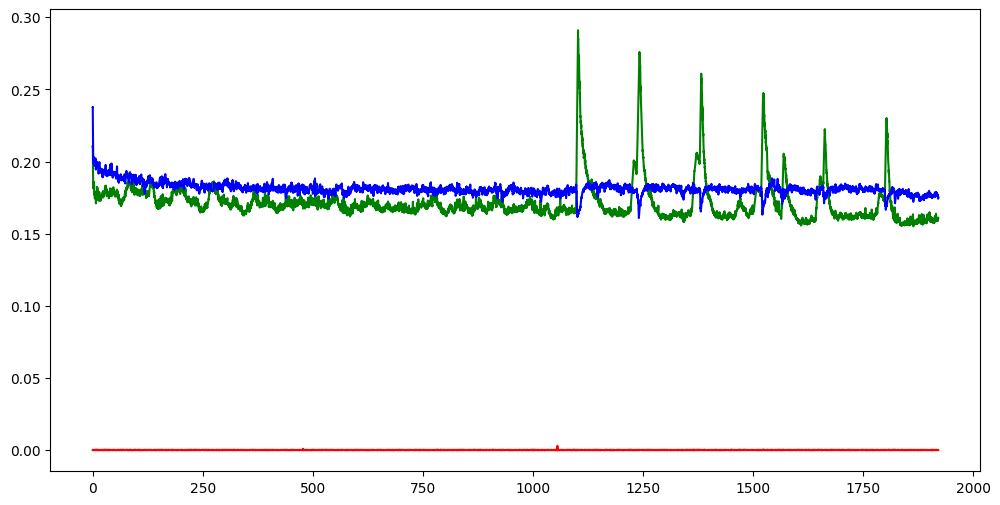

In [40]:
## NOISE CORRECTION 
sampling_rate = 60

b,a = butter(2, 10, btype='low', fs=sampling_rate)
gcamp_denoised = filtfilt(b,a, resampled_gcamp)
iso_denoised = filtfilt(b,a, resampled_iso)
rcamp_denoised = filtfilt(b, a, resampled_rcamp)


##NOISE CORRECTION  PLOT
plt.figure(figsize=(12, 6))
plt.plot(time, gcamp_denoised, color='g', label='Smoothed FP Zscore (Savitzky-Golay)')
plt.plot(time, iso_denoised, color='b')
plt.plot(time, rcamp_denoised, color='r')
# plt.xlim(400, 450)
#ax2.set_ylim(0.6, 1.2)

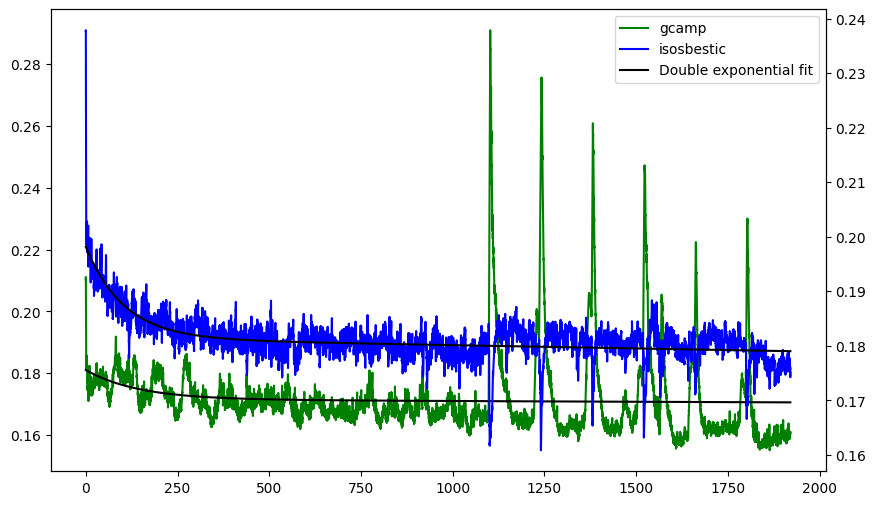

In [41]:
## PHOTOBLEACHING CORRECTION -> Maybe fit only on baseline periods and apply it to everything? 
#Using double exponential fit  

def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):

    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

## Fitting exp to signal 
#Gcamp
max_sig = np.max(gcamp_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 3600  , 0],
          [max_sig, max_sig, max_sig, 6000, 1])
gcamp_params, parm_cov = curve_fit(double_exponential, time, gcamp_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares optimization
gcamp_expfit = double_exponential(time, *gcamp_params)

#Isosbestic
max_sig = np.max(iso_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
iso_params, parm_cov = curve_fit(double_exponential, time, iso_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares 
iso_expfit = double_exponential(time, *iso_params)

#Rcamp
max_sig = np.max(rcamp_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
rcamp_params, parm_cov = curve_fit(double_exponential, time, rcamp_denoised, ## TO APPLY IT ON BASELINE, SET A BASELINE_TIME
                                  p0=inital_params, bounds=bounds, maxfev=1000) ##maxfev = number of iterations for least squares 
rcamp_expfit = double_exponential(time, *rcamp_params)

##PLOTS 

fig,ax1=plt.subplots(figsize=(10,6))  

plot1=ax1.plot(time, gcamp_denoised, 'g', label='gcamp')
plot3=ax1.plot(time, gcamp_expfit, color='k', linewidth=1.5, label='Double exponential fit') 
ax2=plt.twinx()
plot2=ax2.plot(time, iso_denoised, color='b', label='isosbestic') 
plot4=ax2.plot(time, iso_expfit,color='k', linewidth=1.5) 

lines = plot1 + plot2 + plot3
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels); 


(0.0, 4.0)

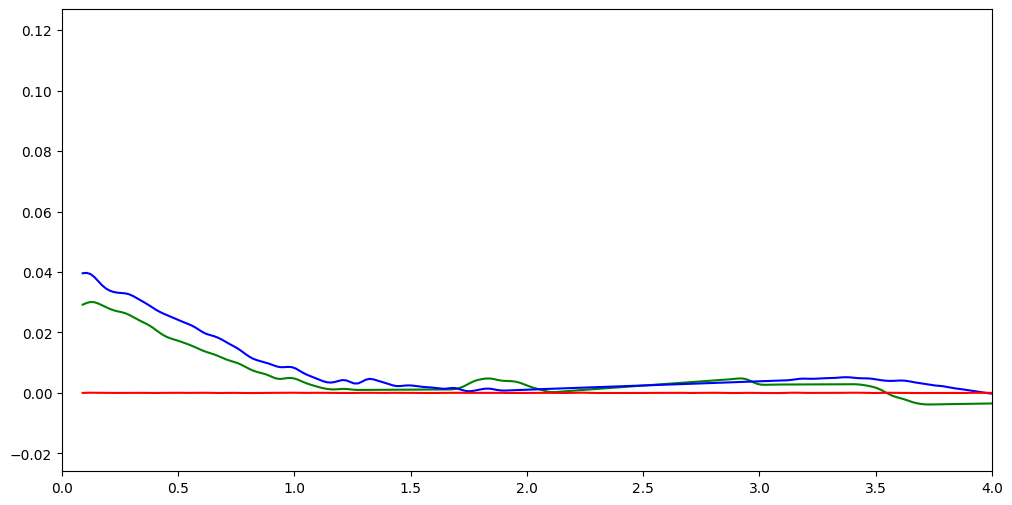

In [42]:
##PHOTOBLEACHING FREE PLOT
gcamp_detrended = gcamp_denoised - gcamp_expfit
iso_detrended = iso_denoised - iso_expfit
rcamp_detrended = rcamp_denoised - rcamp_expfit

plt.figure(figsize=(12, 6))
plt.plot(time, gcamp_detrended, color='g')
plt.plot(time, iso_detrended, color='b')
plt.plot(time, rcamp_detrended, color='r')
plt.xlim(0,4)



(0.0, 5.0)

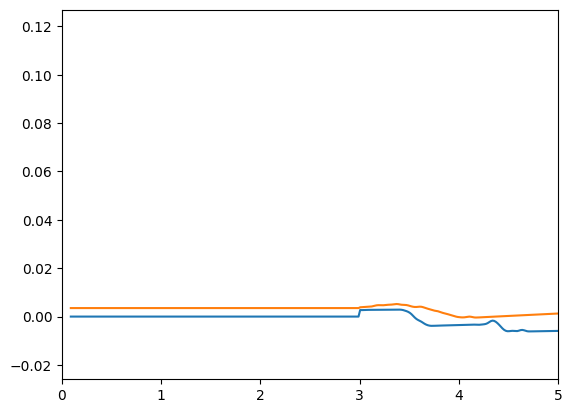

In [43]:
# Find indices for the 3rd second (from 2 to 3 seconds)
indices_3_sec = (time >= 3) & (time < 4)

# Calculate the average values in the 3rd second
gcamp_3_sec_avg = np.mean(gcamp_detrended[indices_3_sec])
iso_3_sec_avg = np.mean(iso_detrended[indices_3_sec])
rcamp_3_sec_avg = np.mean(rcamp_detrended[indices_3_sec])

# Find the indices for the first 2 seconds
indices_2_sec = time < 3

# Set the first 2 seconds to the 3-second average value
gcamp_detrended[indices_2_sec] = gcamp_3_sec_avg
iso_detrended[indices_2_sec] = iso_3_sec_avg
rcamp_detrended[indices_2_sec] = rcamp_3_sec_avg

# Plot results
 

plt.plot(time, gcamp_detrended)
plt.plot(time, iso_detrended)
plt.xlim(0,5)



Slope    : -2.160
R-squared: 0.177


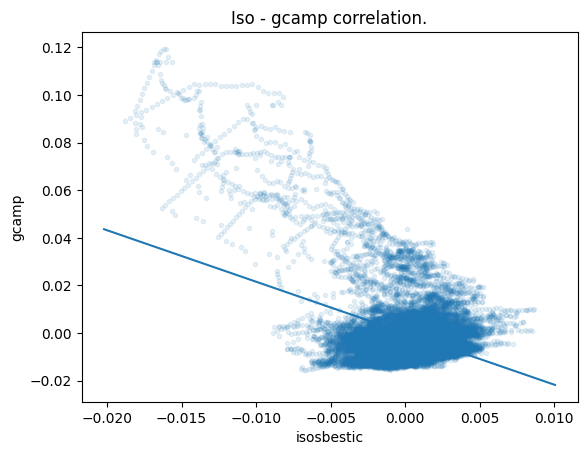

In [44]:
##REMOVING MOVEMENT ARTIFACTS 
##Using linear regression to fit iso to gcamp

slope, intercept, r_value, p_value, std_err = linregress(x=iso_detrended, y=gcamp_detrended) #get regression parameters 

plt.scatter(iso_detrended[::5], gcamp_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x) #Plot the regression line 
plt.xlabel('isosbestic')
plt.ylabel('gcamp')
plt.title('Iso - gcamp correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))


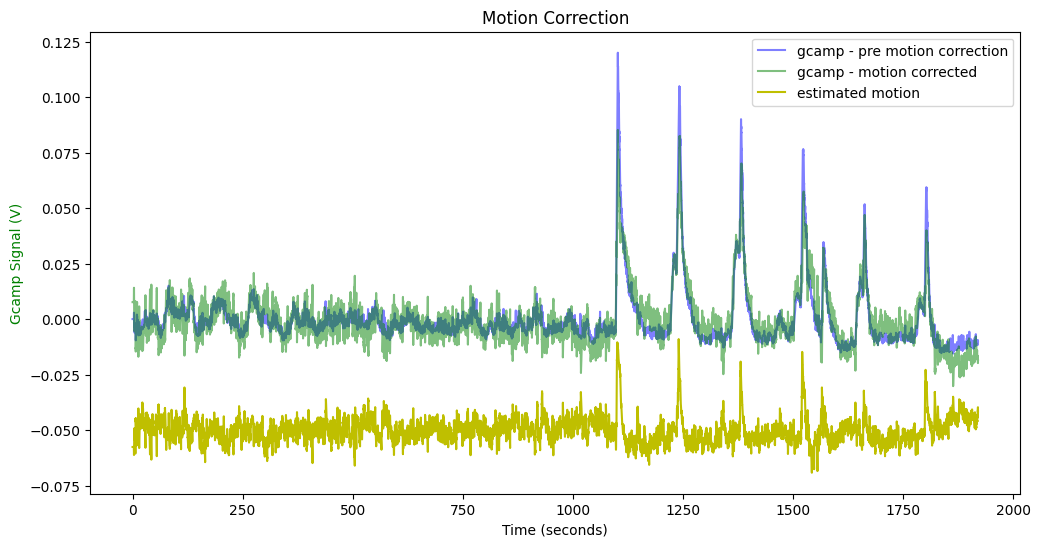

In [45]:
##SUBSTRACTING ESTIMATED MOTION 

gcamp_est_motion = intercept + slope * iso_detrended
gcamp_corrected = gcamp_detrended - gcamp_est_motion

fig,ax1=plt.subplots(figsize=(12,6))  
plot1=ax1.plot(time, gcamp_detrended, 'b' , label='gcamp - pre motion correction', alpha=0.5)
plot3=ax1.plot(time, gcamp_corrected, 'g', label='gcamp - motion corrected', alpha=0.5)
plot4=ax1.plot(time, gcamp_est_motion - 0.05, 'y', label='estimated motion')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Gcamp Signal (V)', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels)

#ax1.set_xlim(0, 460)  # 60 sec window
#ax1.set_ylim(-0.075, 0.1)

Slope    : -0.000
R-squared: 0.000


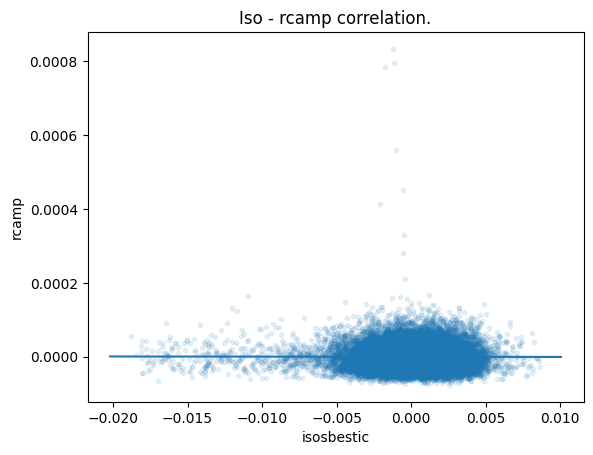

In [46]:
##REMOVING MOVEMENT ARTIFACTS RCAMP 
##Using linear regression to fit iso to gcamp

slope, intercept, r_value, p_value, std_err = linregress(x=iso_detrended, y=rcamp_detrended) #get regression parameters 

plt.scatter(iso_detrended[::5], rcamp_detrended[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x) #Plot the regression line 
plt.xlabel('isosbestic')
plt.ylabel('rcamp')
plt.title('Iso - rcamp correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))


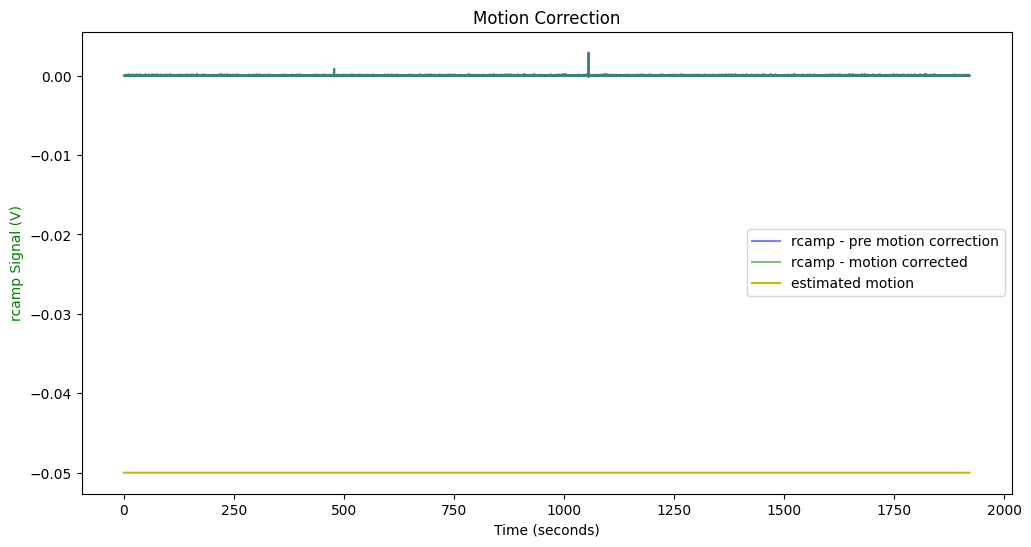

In [47]:
##SUBSTRACTING ESTIMATED MOTION RCAMP 

rcamp_est_motion = intercept + slope * iso_detrended
rcamp_corrected = rcamp_detrended - rcamp_est_motion

fig,ax1=plt.subplots(figsize=(12,6))  
plot1=ax1.plot(time, rcamp_detrended, 'b' , label='rcamp - pre motion correction', alpha=0.5)
plot3=ax1.plot(time, rcamp_corrected, 'g', label='rcamp - motion corrected', alpha=0.5)
plot4=ax1.plot(time, rcamp_est_motion - 0.05, 'y', label='estimated motion')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('rcamp Signal (V)', color='g')
ax1.set_title('Motion Correction')

lines = plot1+plot3+plot4
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels)

# ax1.set_xlim(110, 180)  # 60 sec window
#ax1.set_ylim(-0.075, 0.1)

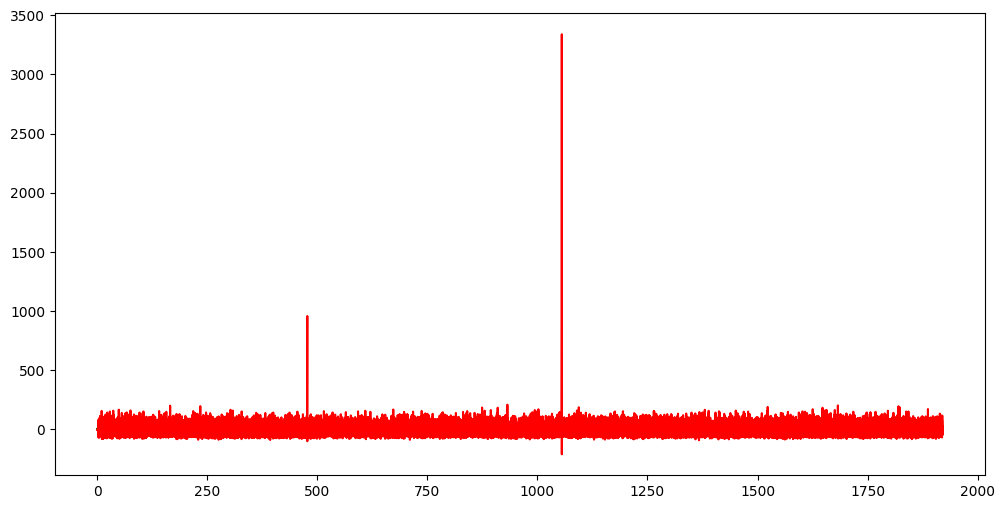

In [48]:
### NORMALIZATION : DF/F
dffg=100*gcamp_corrected/gcamp_expfit
dffr=100*rcamp_corrected/rcamp_expfit

plt.figure(figsize=(12, 6))
plt.plot(time, dffg, color='g')
plt.plot(time, dffr, color='r')
# plt.plot(time, rcamp_est_motion, color='b')
# plt.xlim(250, 360)
#ax1.set_ylim(-3, 3)

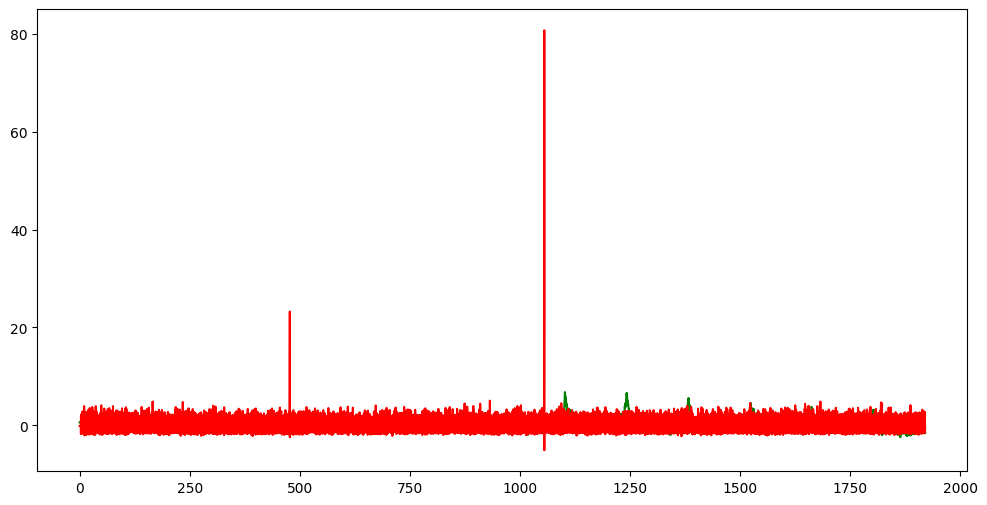

In [49]:
## Normalization : Z-Scoring 
zscoreg = (gcamp_corrected-np.mean(gcamp_corrected))/np.std(gcamp_corrected)
zscorer = (rcamp_corrected-np.mean(rcamp_corrected))/np.std(rcamp_corrected)

plt.figure(figsize=(12, 6))
plt.plot(time, zscoreg, color='g')
plt.plot(time, zscorer, color='r')


#plt.xlim(450, 460)
#ax1.set_ylim(-3, 3);

In [50]:
# ## SMOOTHING
# from scipy.signal import savgol_filter


# polyorder = 2  # Polynomial order
# window_length = 181  # Window length: must be an odd number

# # Apply the filter
# zscore = savgol_filter(zscore, window_length, polyorder)

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(time, zscore, label='Smoothed FP Zscore (Savitzky-Golay)')
# plt.xlabel('Time (s)')
# plt.ylabel('Zscore')
# plt.title('Smoothed FP Signal with Savitzky-Golay Filter')
# plt.legend()
# plt.xlim(30, 65)
# plt.show()

In [51]:
## TTL INPUT TO BEHAVIORAL EVENTS 

#Binarize TTL 
ttl_wn= np.where(resampled_TTL_wn > 0.5, 1, 0)
TTL_wn=ttl_wn
print(len(np.unique(TTL_wn)))

ttl_tone= np.where(resampled_TTL_tone > 0.5, 1, 0)
TTL_tone=ttl_tone
print(len(np.unique(TTL_tone)))




1
1


In [52]:
# TTL extraction 

events = {'start': [], 'end': [], 'type': []}

# Function to process TTL input
def extract_events(TTL, ttl_type):
    sound_on = False
    for i in range(1, len(TTL)):
        if TTL[i] == 1 and TTL[i-1] == 0:  # Sound just turned on
            start_time = time[i]
            sound_on = True
        elif TTL[i] == 0 and TTL[i-1] == 1 and sound_on:  # Sound just turned off
            end_time = time[i]
            events['start'].append(start_time)
            events['end'].append(end_time)
            events['type'].append(ttl_type)
            sound_on = False


extract_events(TTL_tone, 'tone')
extract_events(TTL_wn, 'wn')

events_df = pd.DataFrame(events)
print(events_df)



Empty DataFrame
Columns: [start, end, type]
Index: []


In [53]:
fp_df = pd.DataFrame({'Time': time, 'Zscoreg': zscoreg, 'Zscorer' : zscorer, 'Tone':TTL_tone, 'Wn':TTL_wn})
fp_df

,Time,Zscoreg,Zscorer,Tone,Wn
0,0.089059,0.607350,-0.106826,0,0
1,0.105727,0.607350,-0.106826,0,0
2,0.122396,0.607350,-0.106826,0,0
3,0.139064,0.607350,-0.106826,0,0
4,0.155733,0.607350,-0.106826,0,0
...,...,...,...,...,...
115193,1920.177517,-1.533933,-0.448984,0,0
115194,1920.194185,-1.500704,-0.145366,0,0
115195,1920.210854,-1.469830,-0.132361,0,0
115196,1920.227522,-1.456116,-0.249673,0,0


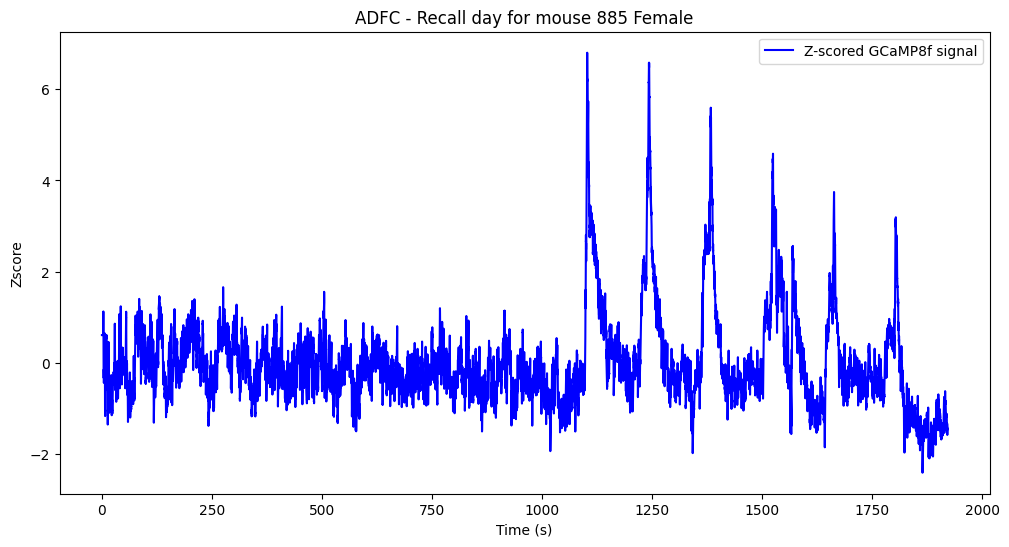

In [54]:
###vizualisation TTL

fig, ax = plt.subplots(figsize=(12, 6))

# Plot Zscore vs. Time
ax.plot(fp_df['Time'], fp_df['Zscoreg'], label='Z-scored GCaMP8f signal', color='b')
# ax.plot(fp_df['Time'], fp_df['Zscorer'], label='zscored rcamp')

# Annotate events
colors = {'wn': 'blue', 'tone': 'orange'}
for _, row in events_df.iterrows():
    ax.axvspan(row['start'], row['end'], color=colors[row['type']], alpha=0.3, label=row['type'])

# Clean up the legend so each label only appears once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_xlabel('Time (s)')
ax.set_ylabel('Zscore')
ax.set_title('ADFC - Recall day for mouse 885 Female')
# ax.set_ylim(-3, 12)
# plt.xlim(110, 300)

plt.show()

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_83397/1312925747.py:48: RuntimeWarning: Mean of empty slice
  psth = np.nanmean(snippets_array, axis=0)
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


ValueError: x and y must have same first dimension, but have shapes (1680,) and (1,)

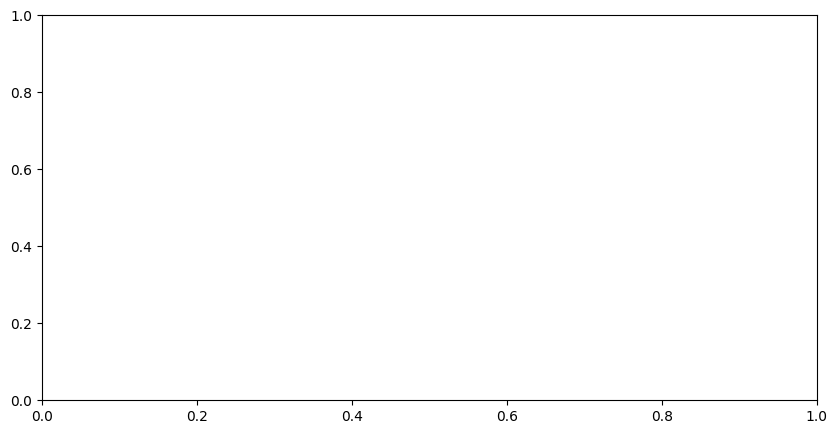

In [55]:

def extract_events(TTL, ttl_type, time):
    events = {'start': [], 'end': [], 'type': []}
    sound_on = False
    for i in range(1, len(TTL)):
        if TTL[i] == 1 and TTL[i-1] == 0:  # Sound just turned on
            start_time = time[i]
            sound_on = True
        elif TTL[i] == 0 and TTL[i-1] == 1 and sound_on:  # Sound just turned off
            end_time = time[i]
            events['start'].append(start_time)
            events['end'].append(end_time)
            events['type'].append(ttl_type)
            sound_on = False
    return events

# Extract events for tone and white noise
events_tone = extract_events(TTL_tone, 'tone', time)
events_wn = extract_events(TTL_wn, 'wn', time)

# Convert to DataFrames
events_tone_df = pd.DataFrame(events_tone)
events_wn_df = pd.DataFrame(events_wn)

# Define the window around event onset
pre_window = 3  # seconds before onset
post_window = 25  # seconds after onset


# Calculate the number of points in the pre and post window
pre_points = int(pre_window * sampling_rate)
post_points = int(post_window * sampling_rate)

def calculate_psth(event_starts, signal, time, pre_points, post_points):
    snippets = []
    for onset in event_starts:
        start_idx = np.searchsorted(time, onset) - pre_points
        end_idx = np.searchsorted(time, onset) + post_points
        if start_idx >= 0 and end_idx <= len(signal):
            snippet = signal[start_idx:end_idx]
            snippets.append(snippet)
        else:
            snippet = np.full(pre_points + post_points, np.nan)  # Initialize with NaNs
            valid_start = max(0, start_idx)
            valid_end = min(len(signal), end_idx)
            snippet[(valid_start - start_idx):(valid_end - start_idx)] = signal[valid_start:valid_end]
            snippets.append(snippet)
    snippets_array = np.array(snippets)
    psth = np.nanmean(snippets_array, axis=0)
    psth_std = np.nanstd(snippets_array, axis=0)
    return psth, psth_std

# Calculate PSTH and STD for tone events
psth_tone, psth_tone_std = calculate_psth(events_tone_df['start'], zscoreg, time, pre_points, post_points)

# Calculate PSTH and STD for white noise events
psth_wn, psth_wn_std = calculate_psth(events_wn_df['start'], zscoreg, time, pre_points, post_points)

# Create a time axis for the PSTH
psth_time = np.linspace(-pre_window, post_window, pre_points + post_points)

# Plot the PSTH for tone
plt.figure(figsize=(10, 5))
plt.plot(psth_time, psth_tone, label='Tone PSTH')
plt.fill_between(psth_time, psth_tone - psth_tone_std, psth_tone + psth_tone_std, alpha=0.2)
plt.axvline(x=0, color='r', linestyle='--', label='Event onset')
plt.xlabel('Time (s)')
plt.ylabel('z-score')
plt.title('PSTH aligned to tone onset')
plt.legend()
plt.show()

# Plot the PSTH for white noise
plt.figure(figsize=(10, 5))
plt.plot(psth_time, psth_wn, label='White Noise PSTH')
plt.fill_between(psth_time, psth_wn - psth_wn_std, psth_wn + psth_wn_std, alpha=0.2)
plt.axvline(x=0, color='r', linestyle='--', label='Event onset')
plt.xlabel('Time (s)')
plt.ylabel('z-score')
plt.title('PSTH aligned to white noise onset')
plt.legend()
plt.show()


In [173]:
# TTL extraction from anymaze file : 


events = {'start': [], 'end': []}

# Function to process TTL input
def extract_events(TTL):
    sound_on = False
    for i in range(1, len(TTL)):
        if TTL_an['Freezing'].iloc[i] == 1 and TTL_an['Freezing'].iloc[i-1] == 0:  # freezing started
            start_time = TTL_an['Time (s)'].iloc[i]
            sound_on = True
        elif TTL_an['Freezing'].iloc[i] == 0 and TTL_an['Freezing'].iloc[i-1] == 1 and sound_on:  #freezing stopped
            end_time = TTL_an['Time (s)'].iloc[i]
            events['start'].append(start_time)
            events['end'].append(end_time)
            sound_on = False

extract_events(TTL_an)
df_freezing = pd.DataFrame(events)
print(df_freezing)


       start       end
0      4.522     6.317
1     13.631    14.762
2    125.073   129.661
3    138.039   163.173
4    167.961   169.556
5    171.352   174.676
6    176.272   183.187
7    185.980   188.374
8    195.621   198.414
9    204.930   206.061
10   206.460   208.787
11   209.186   210.316
12   217.298   218.694
13   219.093   221.553
14   223.482   224.745
15   227.471   229.665
16   232.924   236.115
17   253.537   254.800
18   255.664   257.260
19   275.811   276.942
20   277.673   280.133
21   285.852   287.049
22   289.376   290.706
23   291.105   292.701
24   292.967   297.022
25   298.020   299.416
26   304.270   306.065
27   311.119   313.978
28   314.843   319.031
29   343.035   344.764
30   348.953   352.677
31   366.707   369.100
32   371.694   376.747
33   383.862   386.056
34   442.110   444.770
35   447.096   460.462
36   460.661   469.571
37   490.715   492.178
38   521.967   524.959
39   531.476   533.072
40   580.547   583.273
41   589.856   591.253
42   622.90

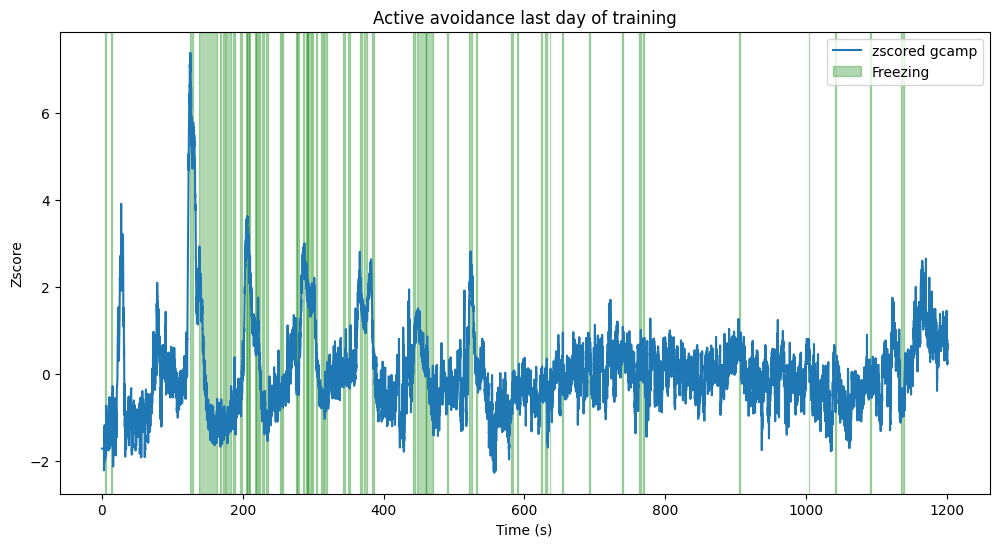

In [174]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Zscore vs. Time
ax.plot(fp_df['Time'], fp_df['Zscoreg'], label='zscored gcamp')
# ax.plot(fp_df['Time'], fp_df['Zscorer'], label='zscored rcamp')

# Annotate events
for _, row in df_freezing.iterrows():
    ax.axvspan(row['start'], row['end'], color='g', alpha=0.3, label='Freezing')

# Clean up the legend so each label only appears once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_xlabel('Time (s)')
ax.set_ylabel('Zscore')
ax.set_title('Active avoidance last day of training')
# ax.set_ylim(-3, 12)
# plt.xlim(40, 460)

plt.show()

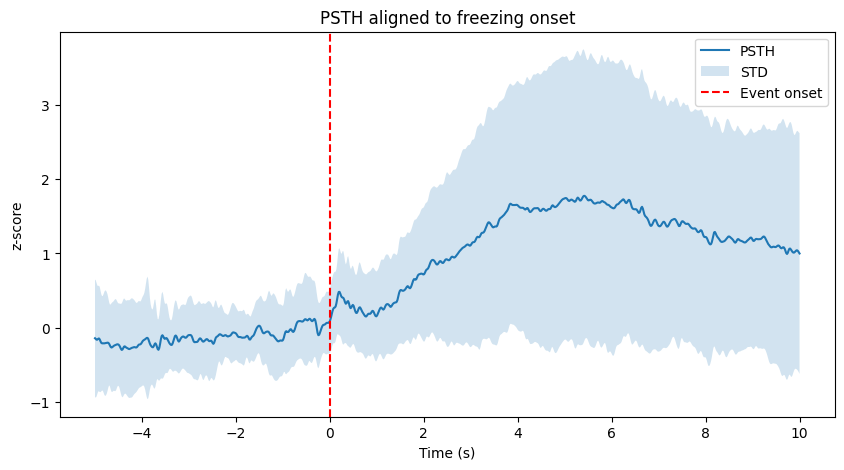

In [175]:

pre_window = 5  # seconds before onset
post_window = 10  # seconds after onset

# Define the sampling rate
sampling_rate = 60  # Assuming constant sampling rate

# Calculate the number of points in the pre and post window
pre_points = int(pre_window * sampling_rate)
post_points = int(post_window * sampling_rate)

# Initialize a list to collect signal snippets
snippets = []

for onset in events_df['start']:
    # Find indices corresponding to the window around each event onset
    start_idx = np.searchsorted(time, onset) - pre_points
    end_idx = np.searchsorted(time, onset) + post_points
    
    # Ensure the indices are within the bounds of the Time array
    if start_idx >= 0 and end_idx <= len(zscoreg):
        snippet = zscoreg[start_idx:end_idx]
        snippets.append(snippet)
    else:
        # Handle cases where the snippet would go out of bounds
        snippet = np.full(pre_points + post_points, np.nan)  # Initialize with NaNs
        valid_start = max(0, start_idx)
        valid_end = min(len(zscoreg), end_idx)
        snippet[(valid_start - start_idx):(valid_end - start_idx)] = zscoreg[valid_start:valid_end]
        snippets.append(snippet)

# Convert list of snippets to a numpy array for easier manipulation 
snippets_array = np.array(snippets)

# Calculate the average and std across all snippets (PSTH)
psth = np.nanmean(snippets_array, axis=0)
psth_std = np.nanstd(snippets_array, axis=0)

# Create a time axis for the PSTH
psth_time = np.linspace(-pre_window, post_window, psth.shape[0])

# Plot the PSTH with std
plt.figure(figsize=(10, 5))
plt.plot(psth_time, psth, label='PSTH')
plt.fill_between(psth_time, psth - psth_std, psth + psth_std, alpha=0.2, label='STD')
plt.axvline(x=0, color='r', linestyle='--', label='Event onset')
plt.xlabel('Time (s)')
plt.ylabel('z-score')
plt.title('PSTH aligned to freezing onset')
plt.legend()
plt.show()


In [176]:

# Add a new column to df_fp to indicate freezing (1 = freezing, 0 = no freezing)
fp_df['Freezing'] = 0  # Start with all 0 (no freezing)

# Iterate over each freezing epoch and mark the freezing periods in df_fp
for i, row in df_freezing.iterrows():
    # Set freezing to 1 where time falls within the freezing start-end interval
    fp_df['Freezing'] = fp_df.apply(lambda x: 1 if row['start'] <= x['Time'] <= row['end'] else x['Freezing'], axis=1)

print(fp_df)


              Time   Zscoreg   Zscorer  Tone  Wn  Freezing
0         0.083083 -1.725476 -1.588701     0   0       0.0
1         0.099753 -1.725476 -1.588701     0   0       0.0
2         0.116423 -1.725476 -1.588701     0   0       0.0
3         0.133093 -1.725476 -1.588701     0   0       0.0
4         0.149763 -1.725476 -1.588701     0   0       0.0
...            ...       ...       ...   ...  ..       ...
72010  1200.495133  0.294765 -1.280602     0   0       0.0
72011  1200.511803  0.225020 -1.350252     0   0       0.0
72012  1200.528473  0.214356 -1.399097     0   0       0.0
72013  1200.545143  0.251932 -1.368947     0   0       0.0
72014  1200.561813  0.311947 -1.261578     0   0       0.0

[72015 rows x 6 columns]


In [177]:
#add mouse ID, sex and day of experiment

fp_df['ID']=mouse_id
fp_df['sex']=sex
fp_df['day']=day_of_experiment
fp_df

,Time,Zscoreg,Zscorer,Tone,Wn,Freezing,ID,sex,day
0,0.083083,-1.725476,-1.588701,0,0,0.0,855,f,day2
1,0.099753,-1.725476,-1.588701,0,0,0.0,855,f,day2
2,0.116423,-1.725476,-1.588701,0,0,0.0,855,f,day2
3,0.133093,-1.725476,-1.588701,0,0,0.0,855,f,day2
4,0.149763,-1.725476,-1.588701,0,0,0.0,855,f,day2
...,...,...,...,...,...,...,...,...,...
72010,1200.495133,0.294765,-1.280602,0,0,0.0,855,f,day2
72011,1200.511803,0.225020,-1.350252,0,0,0.0,855,f,day2
72012,1200.528473,0.214356,-1.399097,0,0,0.0,855,f,day2
72013,1200.545143,0.251932,-1.368947,0,0,0.0,855,f,day2


In [56]:
# #saving the processed df with timestamps and zscoreeees 

# new_filename = f'{mouse_id}_{sex}_{day_of_experiment}_processed.csv'  
# save_folder='/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/ADFCFP/firstbatch0524/preprocessed/'
# save_path = os.path.join(save_folder, new_filename)

# fp_df.to_csv(save_path, index=False)